<a href="https://colab.research.google.com/github/gannygit/interval-analysis-and-transposition/blob/main/Interval_analysis_transposition_and_harmony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scale interval analysis

Author: Bhushan Agarwal/ Gannygit

In this Colab notebook, we will analyse intervals in a given musical scale, find possible transpositions and harmonies (chords) in the scale, and visualise the results. Basic familiarity with python coding as well as elementary music will be beneficial to make the most of this material.

Just read through the text, run all code cells (changing key inputs as needed), and observe the output.

##Introduction
A musical scale contains a set of notes, usually between 5 and 7 notes, spanning an octave. These notes are separated by intervals. An interval is the difference in pitch between two sounds. The interval between any pair of notes can be described in terms of the semitones separating them. For example, the pair (komal re, sa) [or (ri1, sa)] has an interval of 1 semitone, or minor second, which is the same interval as the pair (shuddh ni, sa) [or (ni3, sa)].

For the purposes of this analysis, we will ignore microtones and treat an interval as quantised; thus an interval of 85 cents can be considered 1 semitone. This way, the exact tuning of a scale is irrelevant. Any pitch class or svarasthāna differs from its adjacent pitch classes by 1 semitone.

###Approach
For interval analysis, we only need a symbolic representation of the scale (or a melody); we don't need info about gamaka, fine-tuning (microtones), and musical context (such as ascent and descent).
1. Symbolic score. This depicts the sequence of notes coded as a list (array) of numbers. We will define 0 to represent the tonic note, and all notes above and below it will be represented by the integer number of semitones separating that note from the tonic. Therefore, pa  in the middle octave will be 7, and komal dha (or dha1) in the lower octave will be -4. For example, the sequence of notes in the ascending scale of bilāval/śankarābharaṇam is [0,2,4,5,7,9,11,12].

![chromatic](https://drive.google.com/uc?id=1IJV-6RnTV54TwHcYBeIWThiVjJ2PVSgG)


| Number | Karnatic | Hindustani |Code|
| :- | :- | :- ||
|Lower octave||||
|-12|sa|sa|sa
| -11 | ri1 | komal re |re1
| -10 | ri2/ga1 | shuddh re |re2
| -9 | ri3/ga2 | komal ga |ga1
| -8 | ga3 | shuddh ga |ga2
| -7 | ma1 | shuddh ma |ma1
| -6 | ma2 | tivra ma |ma2
| -5 | pa | pa |pa
| -4 | dha1 | komal dha |dha1
| -3 | dha2/ni1 | shuddh dha |dha2
| -2 | dha3/ni2 | komal ni |ni1
| -1 | ni3 | shuddh ni |ni2
|||||
|Middle octave||||
|0|sa|sa|Sa
| 1 | ri1 | komal re |Re1
| 2 | ri2/ga1 | shuddh re |Re2
| 3 | ri3/ga2 | komal ga |Ga1
| 4 | ga3 | shuddh ga |Ga2
| 5 | ma1 | shuddh ma |Ma1
| 6 | ma2 | tivra ma |Ma2
| 7 | pa | pa |Pa
| 8 | dha1 | komal dha |Dha1
| 9 | dha2/ni1 | shuddh dha |Dha2
| 10 | dha3/ni2 | komal ni |Ni1
| 11 | ni3 | shuddh ni |Ni2
|||||
|Upper octave||||
|12|sa|sa|SA
| 13 | ri1 | komal re |RE1
| 14 | ri2/ga1 | shuddh re |RE2
| 15| ri3/ga2 | komal ga |GA1
| 16 | ga3 | shuddh ga |GA2
| 17 | ma1 | shuddh ma |MA1
| 18 | ma2 | tivra ma |MA2
| 19 | pa | pa |PA
| 20 | dha1 | komal dha |DHA1
| 21 | dha2/ni1 | shuddh dha |DHA2
| 22 | dha3/ni2 | komal ni |NI1
| 23 | ni3 | shuddh ni |NI2


2.  MIDI file. MIDI is short for Musical Instrument Digital Interface. Devices that make and control sound — such as synthesizers, samplers, controllers, and computers  — communicate with each other using MIDI messages. We will create a MIDI file here that can be played using a MIDI player/synthesiser.

In [1]:
pip install mido

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage

###Symbolic score
For our analysis, we need to specify the notes in the scale. We will have to analyse the ascent and descent separately.

In [3]:
# Examples of scales

ascent = np.asarray([0,4,5,7,9]) # change as required; only integer values between 0 and 11 in ascending order
descent = np.asarray([0,4,5,7,9,10]) # change as required; only integer values between 0 and 11 in ascending order
scale = np.asarray([0,1,4,5,7,8,11])

Alternatively, the scales can be represented using musical notation, like below:

In [4]:
scale = ['Sa',"Re1","Ga2","Ma1","Pa","Dha1","Ni2"]

We can then convert this to numerical notation using this dictionary:

In [5]:
note_levels = {
    "sa":-12, "re1":-11, "re2":-10, "ga1":-9, "ga2":-8, "ma1":-7,"ma2":-6,
    "pa":-5, "dha1":-4, "dha2":-3, "ni1":-2, "ni2":-1,
    "Sa": 0, "Re1":1, "Re2": 2, "Ga1":3, "Ga2": 4, "Ma1": 5, "Ma2":6,
    "Pa": 7, "Dha1":8, "Dha2": 9, "Ni1":10, "Ni2": 11,
    "SA": 12, "RE1":13, "RE2": 14, "GA1":15, "GA2": 16, "MA1":17, "MA2":18,
    "PA":19, "DHA1":20, "DHA2":21, "NI1":22, "NI2":23
}

In [6]:
scale = np.asarray(list(note_levels[note] for note in scale))
print(scale)

[ 0  1  4  5  7  8 11]


##Visualising a scale
We will visualise the scale as a one-hot encoded heatmap: 0 for notes that are not present, and 1 for notes that are present in the scale.


In [7]:
# one-hot encoding of one scale
def one_hot_linear(scale):
    one_hot_scale = np.asarray([])
    one = np.asarray([1])
    zero = np.asarray([0])
    for i in range(12):
        if i in scale:
            one_hot_scale = np.append(one_hot_scale,one)
        else:
            one_hot_scale = np.append(one_hot_scale,zero)
    return one_hot_scale.astype(int)

# one-hot encoding of a set of scales
def one_hot_matrix(interval_matrix):
    one_hot_2D = np.arange(12)
    for row in interval_matrix:
        one_hot_2D = np.vstack((one_hot_2D,one_hot_linear(row)))
    return one_hot_2D[1:][:]

We will now define a function to plot the one-hot encoded scales.

In [8]:
def heatmap(data, row_labels, col_labels, ax=None, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    #if cbar_kw is None:
    #    cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), # rotation=-30,
             ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im #, cbar

Testing our functions:

In [9]:
x = np.array([[ 0,  4,  5,  7,  9], # sample data; set of scales. Each row is a scale
       [ 0,  1,  3,  5,  8],
       [ 0,  2,  4,  7,  11],
       [ 0,  2,  5,  9, 10],
       [ 0,  3,  7,  8, 10]])

In [10]:
y = one_hot_matrix(x)
y

array([[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]])

In [11]:
row_labels = np.arange(np.shape(y)[0])
col_labels = ['Sa','Re1','Re2','Ga1','Ga2','Ma1','Ma2','Pa','Dha1','Dha2','Ni1','Ni2']

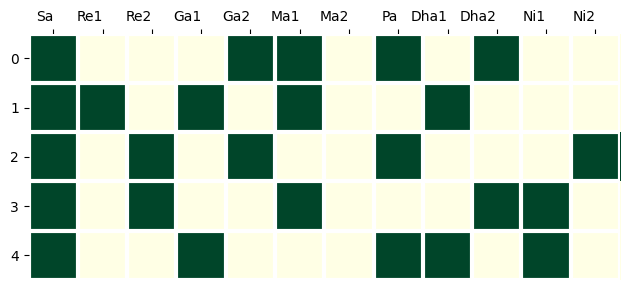

In [12]:
fig, ax = plt.subplots()

im = heatmap(y, row_labels, col_labels, ax=ax,
                   cmap="YlGn")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

Here, each row represents a scale. We will be dealing with sets of related scales, so this visualisation will be useful.

###Colour-coded visualisation

Assigning different colours to each note can help us better visualise how the scales are related to each other.

In [13]:
def graded_linear(scale):
    graded_scale = np.asarray([])
    one = np.asarray([1])
    zero = np.asarray([-1])
    for i in range(12):
        if i in scale:
            graded_scale = np.append(graded_scale,one*i)
        else:
            graded_scale = np.append(graded_scale,zero)
    return graded_scale.astype(int)


def graded_matrix(matrix):
    graded_2D = graded_linear(matrix[0])
    x = graded_linear(matrix[0])
    for i in x:
        if i >=0:
            y = np.concatenate((x[i:],x[:i]))
            graded_2D = np.vstack((graded_2D,y))
    return graded_2D[1:][:]

In [14]:
y = graded_matrix(x)
y

array([[ 0, -1, -1, -1,  4,  5, -1,  7, -1,  9, -1, -1],
       [ 4,  5, -1,  7, -1,  9, -1, -1,  0, -1, -1, -1],
       [ 5, -1,  7, -1,  9, -1, -1,  0, -1, -1, -1,  4],
       [ 7, -1,  9, -1, -1,  0, -1, -1, -1,  4,  5, -1],
       [ 9, -1, -1,  0, -1, -1, -1,  4,  5, -1,  7, -1]])

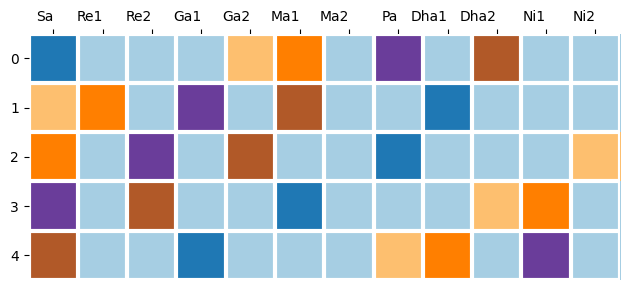

In [15]:
fig, ax = plt.subplots()

im = heatmap(y, row_labels, col_labels, ax=ax,
                   cmap="Paired")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

Here, we can see that each note in a scale corresponds to some other note in each of the other scales. For example, the tonic (sa, 0) in the top row (blue) becomes the minor third (komal ga/ ga2, 3) in the bottom row (blue). All the scales in this set are transpositions of each other.

##Calculating intervals

Now we will calculate the intervals between all pairs of notes in a given scale. This will give us the interval matrix.

In [16]:
def interval_matrix(scale):
    matrix = scale
    for item_1 in scale:
        row = np.asarray([])
        for item_2 in scale:
            difference = item_2 - item_1
            if difference < 0:
                difference += 12
            row = np.append(row,difference)
        matrix = np.vstack((matrix,row))
    return matrix[1:][:].astype(int)


In [17]:
x = interval_matrix(ascent)
print(x)

[[ 0  4  5  7  9]
 [ 8  0  1  3  5]
 [ 7 11  0  2  4]
 [ 5  9 10  0  2]
 [ 3  7  8 10  0]]


We can also display this matrix in musical notations instead of numbers.

In [18]:
def numbers_to_notation(score):
    disp_score = []
    for row in score:
        phrase = []
        for value in row:
            phrase = np.append(phrase,get_key(value))
        #print(phrase)
        if len(disp_score) == 0:
            disp_score = [np.concatenate((disp_score,phrase))]
        else:
            disp_score = np.concatenate((disp_score,[phrase]))

    return disp_score


def get_key(val):

    for key, value in note_levels.items():
        if val == value:
            return key

    return float("nan")

In [19]:
print(numbers_to_notation(x))

[['Sa' 'Ga2' 'Ma1' 'Pa' 'Dha2']
 ['Dha1' 'Sa' 'Re1' 'Ga1' 'Ma1']
 ['Pa' 'Ni2' 'Sa' 'Re2' 'Ga2']
 ['Ma1' 'Dha2' 'Ni1' 'Sa' 'Re2']
 ['Ga1' 'Pa' 'Dha1' 'Ni1' 'Sa']]


##Interpreting the interval matrix
The interval matrices indicate the distance between all pairs of notes in semitones. This distance is directional. We must look horizontally for ascent and vertically for descent. For example, if we have a scale [0,4,5,7,9,10] (sa, shuddh ga/ ga3, shuddh ma/ ma1, pa, shuddh dha/ dha2, komal ni/ ni3) (depicted below),
![scale](https://drive.google.com/uc?id=1Np-WgYQX55kr0KSYRl_LB4ocza_md7n9)


we get the following interval matrix:

![matrix](https://drive.google.com/uc?id=1XBFtuic7JRjKmxuhQxGCFRhWiYo6yLLf)












To see how far above a note is from another, locate the zero of first note and see the number curresponding to the second note's column. For example, if we want to see how far ma (5) is from ga (4), we locate the zero of 4 and read the number in the column titled '5'.

![ascent](https://drive.google.com/uc?id=1XUpJicCvmZw8GQSyCWy-1eC7M8JPW6fQ)











To see how far below a note is from another, locate the zero of the first note and see the number corresponding to the second note's row. For example, if we want to see how far ma (5) is from pa (7), we locate the zero of 7 and read the number in the row titled '5'.

![descent](https://drive.google.com/uc?id=1a1JlIg94OtkxLEzSm7cxU6i38x9xbdPU)


##Transposition/ gṛhabheda

For this, we choose any note from the given scale as the new tonic, and interpret all the other notes (the same notes as in the original scale) relative to this new tonic. For example, starting with the same scale as in the above example, if we choose ma as our new tonic, then the original ga becomes ni.

We can approach transposition in two ways. One is to arrive at a different scale. A reinterpretation of all the notes of a given scale with respect to a new tonic yields a new scale. The other way is to stay in the same scale but hint at other scales by drawing parallels in the intervals.

###Tranposing the tonic

To transpose the tonic of a given scale, read along the row number to which you want to transpose. For example, for the same scale as in the above example [0,4,5,7,9,10], if we want to transpose the tonic to ma (5), just read the scale along that row, and the transposed scale would be [0,2,4,5,7,11].






![ascent](https://drive.google.com/uc?id=1D5dLwcWGyCsGS_zgG2X2y4PNP0uxQCIg)


We must manually check whether this new scale is practically feasible and whether it conforms to theoretical constraints. We can then use this new scale as it is or to inspire phrases in our original scale.

To view all rows as scales starting from zeroes, we need to align all the zeroes and add the upper sa (an octave above the tonic):

In [20]:
def align_tonic(matrix):
    aligned = matrix[0]
    for row in matrix:
        i = int(np.where(row==0)[0])
        y = np.concatenate((row[i:],row[:i]))
        aligned = np.vstack((aligned,y))
    return aligned[1:]


def add_octave(matrix):
    new_matrix = np.concatenate((matrix[0],[12]))
    for row in matrix:
        y = np.concatenate((row,[12]))
        new_matrix = np.vstack((new_matrix,y))
    return new_matrix[1:]


In [21]:
ascent = np.asarray([0,4,5,7,9,10])
x = interval_matrix(ascent)

In [22]:
a = align_tonic(x)
b = add_octave(a)
b

<ipython-input-20-6f7c05daf240>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])


array([[ 0,  4,  5,  7,  9, 10, 12],
       [ 0,  1,  3,  5,  6,  8, 12],
       [ 0,  2,  4,  5,  7, 11, 12],
       [ 0,  2,  3,  5,  9, 10, 12],
       [ 0,  1,  3,  7,  8, 10, 12],
       [ 0,  2,  6,  7,  9, 11, 12]])

We can view these transposed scales in the familiar sargam notation too.

In [23]:
c = numbers_to_notation(b)

In [24]:
print(c)

[['Sa' 'Ga2' 'Ma1' 'Pa' 'Dha2' 'Ni1' 'SA']
 ['Sa' 'Re1' 'Ga1' 'Ma1' 'Ma2' 'Dha1' 'SA']
 ['Sa' 'Re2' 'Ga2' 'Ma1' 'Pa' 'Ni2' 'SA']
 ['Sa' 'Re2' 'Ga1' 'Ma1' 'Dha2' 'Ni1' 'SA']
 ['Sa' 'Re1' 'Ga1' 'Pa' 'Dha1' 'Ni1' 'SA']
 ['Sa' 'Re2' 'Ma2' 'Pa' 'Dha2' 'Ni2' 'SA']]


##Harmony

To build chords, we choose any note from the given scale as the root note, and look at intervals starting from the root note. From the list of available intervals, we can then choose sets of intervals that make up major triads, minor triads, tetrads, sus4 triads, etc.

###Intervals relative to the root note

To find intervals relative to a note, read along the row number corresponding to the note that you want to set as the root. This is the same method used for transposition above.

For example, for the same scale as in the above example [0,4,5,7,9,10], if you want to find all intervals relative to ma (5), just read the scale along that row, which would give [0,2,4,5,7,11].






![ascent](https://drive.google.com/uc?id=1D5dLwcWGyCsGS_zgG2X2y4PNP0uxQCIg)


We can now pick all combinations of intervals from the available relative intervals to make up different kinds of chords.

After algning the zeroes and adding the octave, we get the set of transposed scales that result from interval-preserving transposition of the given scale. We will use it to generate chords.

First, we will define all the chords that we want to consider for our analysis. For now, we will consider only simple triads and tetrads.

In [25]:
chord_list = {"major":[0,4,7],
              "major_7":[0,4,7,11],
              "dominant_7":[0,4,7,10],
              "minor":[0,3,7],
              "minor_7":[0,3,7,10],
              "augmented":[0,4,8],
              "augmented_major_7": [0,4,8,11],
              "augmented_7": [0,4,8,10],
              "diminished":[0,3,6],
              "diminished_major_7":[0,3,6,11],
              "diminished_7":[0,3,6,9],
              "sus_2":[0,2,7],
              "sus_4":[0,5,7]}

We now define a function to look for these chords in the interval matrix.

In [26]:
def find_chords(scale):
    matrix = interval_matrix(scale)
    chords_matrix = []
    label_matrix = []
    for row in matrix:
        chords_row = []
        label_row = []
        for chord in chord_list:
            if set(chord_list[chord]).issubset(row):
                chords_row.append(chord_list[chord])
                label_row.append(chord)
        chords_matrix.append(chords_row)
        label_matrix.append(label_row)

    return chords_matrix,label_matrix

In [27]:
ascent

array([ 0,  4,  5,  7,  9, 10])

In [28]:
find_chords(ascent)

([[[0, 4, 7], [0, 4, 7, 10], [0, 5, 7]],
  [[0, 3, 6]],
  [[0, 4, 7], [0, 4, 7, 11], [0, 2, 7], [0, 5, 7]],
  [],
  [[0, 3, 7], [0, 3, 7, 10]],
  [[0, 2, 7]]],
 [['major', 'dominant_7', 'sus_4'],
  ['diminished'],
  ['major', 'major_7', 'sus_2', 'sus_4'],
  [],
  ['minor', 'minor_7'],
  ['sus_2']])

Chords in numerical score and chords as labels (names) can be stored in two separate variables, like this:

In [29]:
x,l = find_chords(ascent)

In [30]:
x

[[[0, 4, 7], [0, 4, 7, 10], [0, 5, 7]],
 [[0, 3, 6]],
 [[0, 4, 7], [0, 4, 7, 11], [0, 2, 7], [0, 5, 7]],
 [],
 [[0, 3, 7], [0, 3, 7, 10]],
 [[0, 2, 7]]]

To plot the chords with a given root note, we plug in the value of that note's index in the ascent array in the variable `root_index`. For example, if the ascent is `[ 0,  4,  5,  7,  9, 10]`, then `root_index = 2` gives us all chords beginning with Ma (5).

In [31]:
def plot_chords(root_index,chords_matrix,label_matrix,scale):
    if chords_matrix[root_index] == []:
        print("No chords from this root")
        return None
    y = one_hot_matrix(chords_matrix[root_index])

    row_labels = []
    for label in label_matrix[root_index]:
            row_labels.append(label)
    col_labels = ['Sa','Re1','Re2','Ga1','Ga2','Ma1','Ma2','Pa','Dha1','Dha2','Ni1','Ni2']
    col_labels = col_labels[scale[root_index]:] + col_labels[:scale[root_index]]


    fig, ax = plt.subplots()

    im = heatmap(y, row_labels, col_labels, ax=ax, cmap="YlGn")

    fig.tight_layout()
    plt.show()



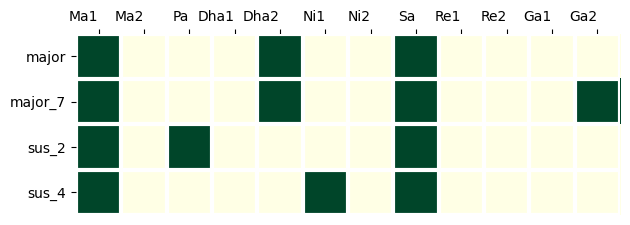

In [32]:
plot_chords(root_index = 2, chords_matrix = x, label_matrix = l, scale = ascent)

In [33]:
def plot_all_chords(scale,chords_matrix,label_matrix):

    y = one_hot_matrix([scale])

    for index,row in enumerate(chords_matrix):
        #print(f"current index: {index}, row: {row}")
        if row == []:
            continue
        row = unalign(row,scale[index])
        for list in row:
            y = np.vstack((y,one_hot_matrix([list])))
        #print(f"one_hot_updated: {y}")


    col_labels = ['Sa','Re1','Re2','Ga1','Ga2','Ma1','Ma2','Pa','Dha1','Dha2','Ni1','Ni2']
    row_labels = ['full_scale']
    for index,row in enumerate(label_matrix):
        for label in row:
            row_labels.append(f"{col_labels[scale[index]]}, "+label)

    fig, ax = plt.subplots()

    im = heatmap(y, row_labels, col_labels, ax=ax,
                    cmap="YlGn")

    ax.set_title("Chords")

    fig.tight_layout()
    plt.show()

    return None


def unalign(row,degree):
    unaligned_list = []
    for list in row:
        new_list = [(n+degree)%12 for n in list]
        unaligned_list.append(new_list)

    return unaligned_list

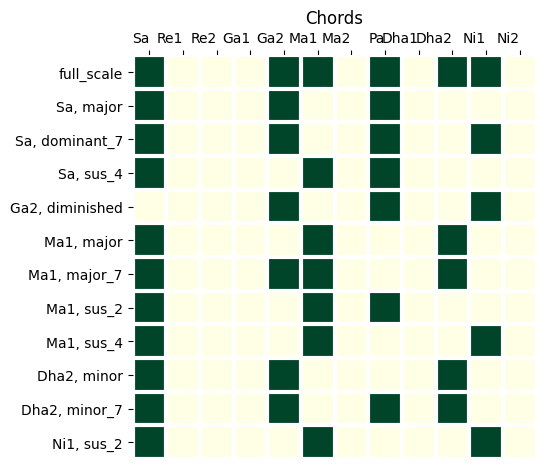

In [34]:
plot_all_chords(ascent,x,l)

##Hearing the scales in MIDI
We can generate MIDI files to hear the scales. For this, we need to specify a scale and the fine tuning.

In [35]:
scale_1 = [0,4,5,7, 9,10]
chromatic_ascent = [0,1,2,3,4,5,6,7,8,9,10,11] # set of all permissible notes in a scale; only middle octave; scope: global; do not edit
c_n = [0,0,0,0,0,0,0,0,0,0,0,0] # fine tuning in cents; change as required

Additionally, we need a function to extract the position of a given pitch class relative to A. We are using a function here that returns this position as well as the actual frequency of the note, but we don't need the value of frequency for this analysis.

In [36]:
def note_to_freq(note):
    if len(note) < 2 or len(note) > 3 or note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f,n

We also need a function to convert a score from our convention (where sa = 0) to MIDI note numbers.

In [37]:
def score_to_MIDI_score(score,ascent,tonic_note):
    MIDI_score = []
    tonic_f,n = note_to_freq(tonic_note)
    n = n+57 +12
    i = 0
    for row in score:
        for chord in row:
            #print(f"current chord: {chord}")
            MIDI_chord = []
            for note in chord:
                MIDI_chord.append(note+n+ascent[i])
            #print(f"appending chord: {MIDI_chord}")
            MIDI_score.append(MIDI_chord)
            #print(f"current score: {MIDI_score}")
        i+=1
    return(MIDI_score)

def scale_to_MIDI_scale(scale,tonic_note):
    MIDI_score = np.asarray([])
    tonic_f,n = note_to_freq(tonic_note)
    n = n+57 +12
    for note in scale:
        MIDI_score = np.append(MIDI_score,note+n).astype(int)
    return(MIDI_score)

Testing the functions

In [38]:
tonic_note='C3'

In [39]:
x

[[[0, 4, 7], [0, 4, 7, 10], [0, 5, 7]],
 [[0, 3, 6]],
 [[0, 4, 7], [0, 4, 7, 11], [0, 2, 7], [0, 5, 7]],
 [],
 [[0, 3, 7], [0, 3, 7, 10]],
 [[0, 2, 7]]]

In [40]:
ascent

array([ 0,  4,  5,  7,  9, 10])

In [41]:
score_to_MIDI_score(x,ascent,tonic_note)

[[48, 52, 55],
 [48, 52, 55, 58],
 [48, 53, 55],
 [52, 55, 58],
 [53, 57, 60],
 [53, 57, 60, 64],
 [53, 55, 60],
 [53, 58, 60],
 [57, 60, 64],
 [57, 60, 64, 67],
 [58, 60, 65]]

In [42]:
scale_to_MIDI_scale(ascent,tonic_note)

array([48, 52, 53, 55, 57, 58])

We will use the following function to create a MIDI file for our scale and chord matrix.

In [43]:
def create_midi_file(MIDI_score, ascent, c_n, tonic_note, bpm = 80):

    temp=int(1000000*60/bpm)
    octave = ascent[0] + 12

    # Create a MIDI file and a track
    midi_file = MidiFile()
    track = MidiTrack()
    midi_file.tracks.append(track)

    # Set the instrument (program) for the track (optional)
    track.append(Message('program_change', program=0, time=0))

    # Set the tempo
    track.append(MetaMessage('set_tempo', tempo=temp, time=0))

    bend_value = 0

    MIDI_ascent = scale_to_MIDI_scale(add_octave([ascent])[0],tonic_note)
    # Add note-on and note-off messages for each note of the scale
    for note_pitch in MIDI_ascent:
        if note_pitch == octave:
            time = 480
        else:
            time = 0

        # Note On message
        track.append(Message('note_on', note=note_pitch, velocity=100, time=0))

        # Fine-tuning the pitch
        index = MIDI_note_to_index(note_pitch, chromatic_ascent, tonic_note)
        if(c_n[index] != 0 or bend_value != 0):
            bend_value = int(c_n[index]*8191/200) # works only for pitch bend range of +/- 2 semitones
            track.append(Message('pitchwheel', pitch=bend_value, time=0))

        # Note Off message (assuming a duration of 1 beat for each note, except for the upper sa, which lasts 2 beats)
        track.append(Message('note_off', note=note_pitch, velocity=100, time=480+time))  # 480 ticks = 1 beat

    # adding chords
    for chord in MIDI_score:
        chord_start = True
        for note_pitch in chord:
            # Note On message
            track.append(Message('note_on', note=note_pitch, velocity=100, time=0))

            # Fine-tuning the pitch
            index = MIDI_note_to_index(note_pitch, chromatic_ascent, tonic_note)
            if(c_n[index] != 0 or bend_value != 0):
                bend_value = int(c_n[index]*8191/200) # works only for pitch bend range of +/- 2 semitones
                track.append(Message('pitchwheel', pitch=bend_value, time=0))

        for note_pitch in chord:
            if chord_start:
                time = 480*2    # 480 ticks = 1 beat
            # Note Off message
            track.append(Message('note_off', note=note_pitch, velocity=100, time=time))
            time = 0
            chord_start = False

    return(midi_file)

def MIDI_note_to_index(note,ascent,tonic_note):
    MIDI_ascent = scale_to_MIDI_scale(ascent,tonic_note)
    #print(f"MIDI_ascent = {MIDI_ascent}, note = {note}")
    index = int(np.where(MIDI_ascent%12 == note%12)[0])
    return index

Let's define an analysis function so we can just call that function to analyse various scales.

In [44]:
def interval_analysis(ascent,c_n, filename, tonic_note='C3',bpm=160, reg_colour = False, note_levels = note_levels):
    x = interval_matrix(ascent) # calculating the interval matrix
    aligned_matrix = align_tonic(x) # aligning the tonics
    aligned_matrix = add_octave(aligned_matrix) # adding the upper sa to each scale
    aligned_scales = numbers_to_notation(aligned_matrix)

    # creating and saving a MIDI file
    score, l = find_chords(ascent)
    MIDI_score = score_to_MIDI_score(score,ascent, tonic_note)
    midi_file = create_midi_file(MIDI_score, ascent, c_n, tonic_note,bpm)
    midi_file.save(filename+'.mid')
    print("MIDI file saved as "+filename+'.mid')

    # visualising the interval matrix
    if reg_colour == False:
        y = graded_matrix(x)
        palette = 'Paired'
    else:
        y = one_hot_matrix(x)
        palette = 'YlGn'

    fig, ax = plt.subplots()
    row_labels = np.arange(np.shape(y)[0])
    col_labels = ['Sa','Re1','Re2','Ga1','Ga2','Ma1','Ma2','Pa','Dha1','Dha2','Ni1','Ni2']
    im = heatmap(y, row_labels, col_labels, ax=ax,
                    cmap=palette)
    ax.set_title("Transposition")
    fig.tight_layout()
    plt.show()

    plot_all_chords(ascent,score,l)
    '''
    # visualising the scales as graphs
    score = numbers_to_notation(aligned_matrix)
    G = construct_graph_from_phrases(score)
    visualize_graph(G, score, note_levels)
    '''

##Examples

We will initialise the tonic to C3 and tempo to 160 bpm for all examples. We will also define the fine-tuning parameters.

In [45]:
tonic_note = 'C3' # specifying the tonic note
bpm = 160 # tempo in beats per minute

chromatic_ascent = [0,1,2,3,4,5,6,7,8,9,10,11] # set of all permissible notes in a scale; only middle octave; scope: global; do not edit
c_n = [0,0,0,0,0,0,0,0,0,0,0,0] # fine tuning in cents; change as required

###Example 1

In [46]:
scale_1 = [0,2,4,5,7,11]

<ipython-input-20-6f7c05daf240>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])
<ipython-input-43-09c221bf30c4>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.where(MIDI_ascent%12 == note%12)[0])


MIDI file saved as scale_1.mid


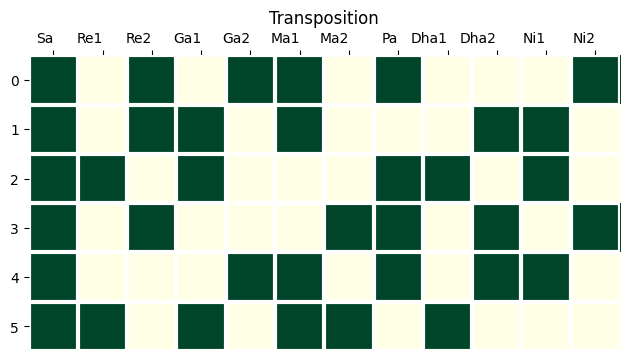

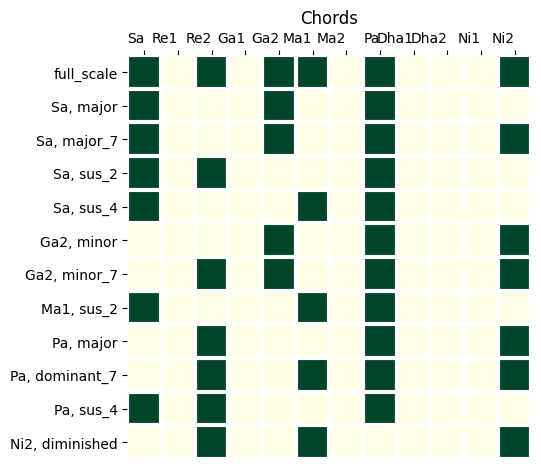

In [47]:
interval_analysis(scale_1,c_n, filename='scale_1', tonic_note='C3',bpm=160, reg_colour = True)

###Example 2

In [48]:
scale_2 = [0,2,4,7,11]

<ipython-input-20-6f7c05daf240>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])
<ipython-input-43-09c221bf30c4>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.where(MIDI_ascent%12 == note%12)[0])


MIDI file saved as scale_2.mid


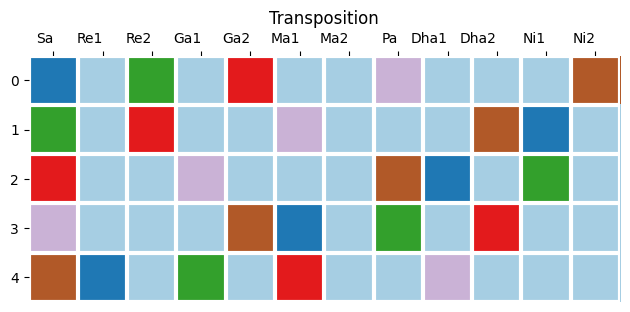

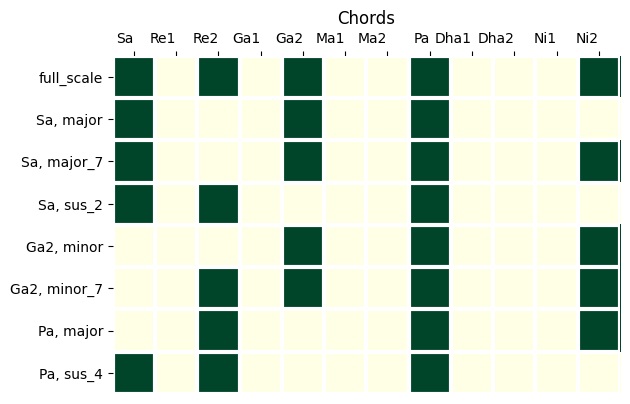

In [49]:
interval_analysis(scale_2,c_n, filename='scale_2', tonic_note='C3',bpm=160, reg_colour = False)

###Example 3
Enter your own example scale and parameters below.

In [50]:
scale_3 = [0,4,7] # specify the notes in your scale; only integers between 0 and 11, in ascending order
filename = "scale_3" # specify the file name you want to save the MIDI file with
tonic_note = "C3"
colour = False # set to True for regular visualisation, and False for colour-coded visualisation
c_n = [0,0,0,0,0,0,0,0,0,0,0,0] # fine tuning in cents; change if required

<ipython-input-20-6f7c05daf240>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])
<ipython-input-43-09c221bf30c4>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.where(MIDI_ascent%12 == note%12)[0])


MIDI file saved as scale_3.mid


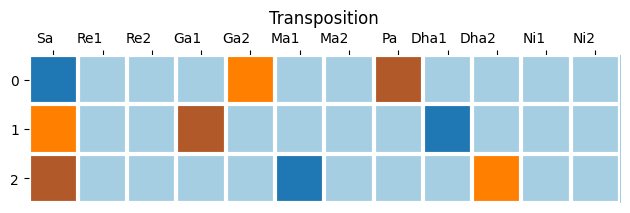

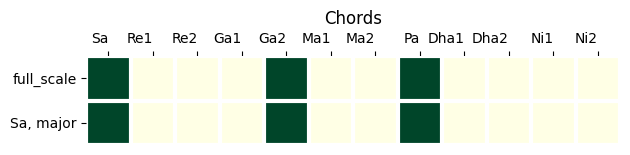

In [51]:
interval_analysis(scale_3,c_n, filename, tonic_note,bpm=160, reg_colour = colour)